In [1]:
import re
import pandas as pd
import os
import numpy as np
import sys
import matplotlib.pyplot as plt
import json
%matplotlib inline

rootdir = '/Users/lguillain/Documents/EPFL2018/Git-semester-project/data/papers/'

## loading content of txt files..

In [2]:
contents = []
i = 0
source = []
for subdir, dirs, files in os.walk(rootdir):
    for file in files:
        if 'txt' in file:
            i += 1
            path = os.path.join(subdir, file)
            with open(path) as file:
                try:
                    text = file.read()
                    contents.append(text)
                    source.append(path[len(rootdir):-4])
                except:
                    name, message, content = sys.exc_info()
                    print(message)

## extracting the reference function from the text

One attempt was to use special splitting:

In [3]:
#Example of extraction
t = 'Abrahamson, D. (2012). Discovery reconceived: Product before process. For the Learning of Mathematics, 32(1), 815.\nAbrahamson, D. (2015). The monster in the machine, or why educational technology needs embodied design. In\nV. R. Lee (Ed.),'
re.split(r'(?<=\.)\n', t)

['Abrahamson, D. (2012). Discovery reconceived: Product before process. For the Learning of Mathematics, 32(1), 815.',
 'Abrahamson, D. (2015). The monster in the machine, or why educational technology needs embodied design. In\nV. R. Lee (Ed.),']

In [4]:
#dealing with links at the end
t =  'dispositions. Science Education, 98(1), 36–63. https://doi.org/10.1002/sce.21083\nEdelson, D. C., & Joseph, D. M. (2004). The interest-driven learning design framework: motivating learning'
re.split(r'\n\n|((?<=(\.|\/|[a-z]))\n)|\n(?=[A-Z])',t)

['dispositions. Science Education, 98(1), 36–63. https://doi.org/10.1002/sce.21083',
 None,
 None,
 'Edelson, D. C., & Joseph, D. M. (2004). The interest-driven learning design framework: motivating learning']

#### The issue is that it undersplits, so we it's better to just use \n 

In [5]:
def ref_extraction(text, extract=False):
    """extracts refrerence section: works well on well formated documents"""
    mention = text.rfind("\nReferences")
    if mention == -1:
        mention = text.lower().rfind(" references")
    if mention == -1:
        mention =  text.lower().rfind("reference")
    #get reference section, account for different spelling
    acknowledgements = max(text.lower().find("acknowledgements"), text.lower().find('acknowledgments'))
    
    #handle case that acknowlege ments are before references
    if acknowledgements < mention:
        acknowledgements = -1
    ref = text[mention+len("references"):acknowledgements]
    
    #references = re.split(r'\n\n|((?<=(\.|\/|[a-z]))\n)|\n(?=[A-Z])',ref)
    references = re.split(r'\n', ref)
    
    ref = [r for r in references if r and len(r) > 3 and not re.match(r'(CSCL|ICLS) \d{4} Proceedings|© ISLS', r)]
    if extract:
        print(text[mention+len("references"):acknowledgements])
        print(references)
    return ref

In [6]:
references = []
for i, content in enumerate(contents):
    references.append((ref_extraction(content)))

In [7]:
print('Number of pdf documents : ', len(contents))
print('Number of documents for which we have an extracted reference section: ', len(references))

Number of pdf documents :  874
Number of documents for which we have an extracted reference section:  874


# looking into regex to check if valid:

One way we can know a line was split early is if it starts with lowercase letter or with a number

This is old code that was used at some point but is not no longer used 

In [8]:
def match_url(sentence):
    return re.search('http(s)?\:\/\/[\S]*$', sentence) or re.search(r'doi\:[\S\/\*]*$', sentence)

def match_url_beginning(sentence):
    return re.search('^http(s)?\:\/\/[\S]*$', sentence) or re.search(r'^doi\:[\S\/\*]*$', sentence)

def show_issue(issues, condition):
    for issue in issues:
        if condition(issue):
            print(issue)

Central approach is to move sentences up until they are part of a string that contains a citation year, which usually is at the beginning of a string in an APA reference 

In [9]:
def contains_citation_beginning(sentence):

    ##Check for mention of publication date,
    #do it this way to not allow for ICLS 2015 string to be counted
    months = '(january|february|march|april|may|june|july|august|september|october|november|december)?'
    publication_year = r'(?<!\d)\('+months+'[\-\ ]*'+months+'[\ \,]*(18|19|20)\d{2}[a-z]?[\,\ ]*'+months+'[\-\ \d]*'+months+'\)'
    #sometimes two years are mentioned, we use this regex to parse them
    match_bad_year = r'\((18|19|20)\d{2}\/(18|19|20)\d{2}\)'
    
    #these regex account for special strings used in the references
    match_press = r'[\w\ \. \,\&\(\)\-\'\…]*\(in press\)'
    match_forth = r'[\S\s]*\(forthcoming\)'
    match_accepted = r'[\S\s]*\(accepted\)'
    match_submitted = r'[\S\s]*\(submitted\)'
    match_underreview = r'[\S\s]*\(under review\)'
    sentence = sentence.lower()
        
    year = re.search(publication_year, sentence) or  re.search(match_bad_year, sentence)
    
    return  year or \
            re.match(match_press, sentence) or re.match(match_forth, sentence) or\
            re.match(match_accepted, sentence) or re.match(match_submitted, sentence) or\
            re.match(match_underreview, sentence)

Example of parsing working:

In [10]:
sentence = 'Xing, W., Kim, S., & Goggins, S. (2015/1994). Modeling performance in asynchronous CSCL: an exploration of social ability, collective efficacy and social interaction. Exploring the Material Conditions of Learning: Proceedings of the Computer Supported Collaborative Learning (CSCL 2015), International Society of'
sentence_2 = 'Engeström, Y. (1987/2014) Learning by expanding: An activity-theoretical approach to developmental research (2nd ed.). New York, NY: Cambridge University Press.'

months = '(january|february|march|april|may|june|july|august|september|october|november|december)?'
publication_year = r'(?<!\d)\('+months+'[\-\ ]*'+months+'[\ \,]*(18|19|20)\d{2}[a-z]?[\,\ ]*'+months+'[\-\ ]*'+months+'\)'


match_bad_year = r'\((18|19|20)\d{2}\/(18|19|20)\d{2}\)'

month = re.search(publication_year, sentence.lower())
conference =  re.search(match_bad_year, sentence_2)
    
conference, month

(<re.Match object; span=(14, 25), match='(1987/2014)'>, None)

In [11]:
#moving sentences starting with lowercase letter or number strings "one up"
def moving_up(issues, condition=lambda x: re.match('^[\d\(\.\&\ ]', x)):

    issues = [i for i in issues if len(i) > 0]
    patchwork = []
    j = 0
    
    for i, sentence in enumerate(issues):
        if i != 0 and condition(sentence):
            patchwork[j-1] += ' ' + sentence
            #print(sentence)
        else:
            j +=1
            patchwork.append(sentence)
    patchwork = [p for p in patchwork if len(p) > 0]
    
    return patchwork

In [12]:
#iteration 1: move up strings that start in number or with (
ref_1 = [moving_up(r) for r in references]
#iteration 2: move up string starting with "Proceedings"
ref_2 = [moving_up(r, lambda x: re.match('^Proceedings', x)) for r in ref_1]

In [13]:
#moving sentences starting with lowercase letter or number strings "one up"
def moving_down(issues, condition=lambda x: re.match('^[\d\(\.]', x)):

    issues = [i for i in issues if len(i) > 0]
    patchwork = issues.copy()
    j = 0
    
    for i, sentence in enumerate(issues):
        if condition(sentence) and i+1 < len(issues):
            patchwork[i] = sentence + ' ' + patchwork[i+1]
            patchwork[i+1] = ''

    patchwork = [p for p in patchwork if len(p) > 0]
    
    return patchwork

In [14]:
cutoff_name = r'^[A-Z]+\.\ ?'
text = 'G. bsdjhvshjvf(1220)'
re.match(cutoff_name, text)

<re.Match object; span=(0, 3), match='G. '>

In [15]:
text = 'Walther, J. B., & Parks, M. R. (2002). Cues filtered out, cues filter in: computer mediated communication and'
words_at_end = r'\ [a-zA-Z]*$'
re.search(words_at_end, text)

<re.Match object; span=(105, 109), match=' and'>

In [16]:
#move up is name is cut off (for instance, sentence starts with C. ....)
ref_3 = [moving_up(r, lambda x: re.match(cutoff_name, x)) for r in ref_2]

For references we might cut off the year from the authors. In that case we need to change strategy and move the one that is below up if the upper string satisfies the condition

In [17]:
def match_author(authors):
    regex = r'(([\w\-]*[\,\&] [A-Z\.\ ]+[\&\,]?)*$)'
    USA = r'([A-Z]{2,})'
    return not re.search(USA, authors) and re.match(regex, authors)

In [18]:
sentence = 'Yoon, S., Anderson, E., Koehler-Yom, Evans, C., Park, M., J., Sheldon, J., Schoenfeld, I., Wendel, D.,'
match_author(sentence).group(0)

'Yoon, S., Anderson, E., Koehler-Yom, Evans, C., Park, M., J., Sheldon, J., Schoenfeld, I., Wendel, D.,'

In [19]:
ref_4 = [moving_down(r, lambda x: match_author(x)) for r in ref_3]

#pivoting up around strings containing citation
ref_5 = [moving_up(r, lambda x: not contains_citation_beginning(x)) for r in ref_4]
#if ends in word
ref_6 = [moving_down(r, lambda x: re.search(words_at_end, x)) for r in ref_5]

Add the reference isnto dataframe, associating the source text to it:

In [20]:
references_df = pd.DataFrame([(f, source[i]) for i, flat in enumerate(ref_6) for f in flat], columns=['ref', 'file'])

We use length and initial of the reference to preform a sanity check:

In [21]:
references_df['length'] = references_df.ref.map(lambda x: len(x))
references_df['initial'] = references_df.ref.map(lambda x: x[0])

count    14686.000000
mean       194.962345
std        685.649075
min          4.000000
25%        139.000000
50%        180.000000
75%        219.000000
max      74737.000000
Name: length, dtype: float64

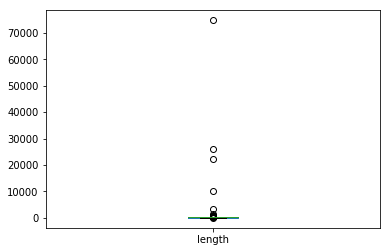

In [22]:
references_df.length.plot(kind='box')
references_df.length.describe()

In [23]:
references_df[references_df.length > 1000]

,ref,file,length,initial
114,p ...............................................,import2016full_93,22395,p
862,nalysis .........................................,import2016full_92,74737,n
1897,Pages 1-702: Volume 1 Pages 703-1407: Volume 2...,import2016full_91,26188,P
9343,for collaborative learning moderates the relat...,import2016short_136,3336,f
10746,"Dijkstra, Pieternel, Hans Kuyper, Greetje van ...",import2018_323,1335,D
12489,"Wenger, E. (1998). Communities of practice: Le...",import2016short_145,10097,W


One paper that uses ACM format:

In [24]:
references_df.iloc[10746].ref

'Dijkstra, Pieternel, Hans Kuyper, Greetje van der Werf, Abraham P. Buunk, and Yvonne G. van der Zee. 2008. “Social Comparison in the Classroom: A Review.” Review of Educational Research 78 (4). American Educational Research Association:828–79. Festinger, Leon. 1954. “A Theory of Social Comparison Processes.” Human Relations; Studies towards the Integration of the Social Sciences 7 (2). SAGE Publications:117–40. Graesser, Arthur C., Danielle S. McNamara, Zhiqang Cai, Mark Conley, Haiying Li, and James Pennebaker. 2014. “Coh-Metrix Measures Text Characteristics at Multiple Levels of Language and Discourse.” The Elementary School Journal 115 (2):210–29. Régner, Isabelle, and Jean-Marc Monteil. 2007. “Low-and High-Socioeconomic Status Students Preference for Ingroup Comparisons and Their Underpinning Ability Expectations.” Revue Internationale de Psychologie Sociale 20 (1). Presses univ. de Grenoble:87–104. Tu, Chih-Hsiung, and Marina McIsaac. 2002. “The Relationship of Social Presence an

h    4
p    3
b    3
Ö    3
n    2
t    2
e    2
a    2
[    1
1    1
f    1
Ø    1
Å    1
Ž    1
r    1
Name: initial, dtype: int64

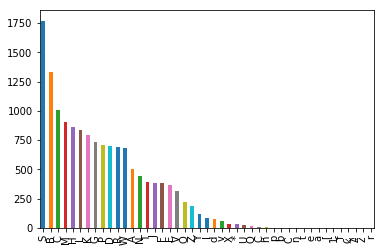

In [25]:
references_df.initial.value_counts().plot(kind='bar')
references_df.initial.value_counts().tail(15)

In [26]:
#short references are fine
references_df[references_df.length < 40]

,ref,file,length,initial
3724,"Wilensky, U. (1999). {NetLogo}.",import2017_9,31,W
4140,"Wilensky, U. (1999). {NetLogo}.",import2018_1,31,W
5093,"Wilensky, U. (1999). {NetLogo}.",import2016short_106,31,W
6391,1855,import2018_513,4,1
9378,no. 1 (2000): 1–25.,import2018_269,19,n


In [27]:
#also correctly parsed i, e are fine, a are not too bad, leave it
#only very few references are incorrect if they start by lowercase. we accept this
#b is correct
references_df[references_df['initial'] == 'b']

,ref,file,length,initial
3045,"boyd, d. (2014). It’s complicated: The social ...",import2018_176,109,b
3671,"boyd, d. (2009). Why Youth (Heart) Social Netw...",import2015full_285,110,b
4620,"boyd, d. (2009). Why Youth (Heart) Social Netw...",import2015short_285,110,b


Remove overly long references are they are due to badly parsed pdfs:

In [28]:
references_df = references_df[(references_df.length < 1000)]

In [29]:
print('We can parse references from {} documents.'.format(references_df.file.value_counts().shape[0]))

We can parse references from 865 documents.


Example reference:

In [30]:
references_df[references_df.length < 200].sample(5).ref.tolist()

['Walther, J. B. (2002). Time effects in computer-mediated groups: Past, present, and future. Distributed Work, 235–257. JOUR.',
 'Papert, S. (1980). Mindstorms: Children, computers, and powerful ideas. Basic Books, Inc.',
 'Tenenberg, J., & Fincher, S. (2007, March). Opening the door of the computer science classroom: the disciplinary commons. In ACM SIGCSE Bulletin (Vol. 39, No. 1, pp. 514-518). ACM.',
 'Wood, D., Bruner, J. S., & Ross, G. (1976). The role of tutoring in problem solving. Journal of Child Psychology and Child Psychiatry, 17, 89-100.',
 'Penuel, W. R., Frank, K. A., Sun, M., Kim, C. M., & Singleton, C. A. (2013). The organization as a filter of institutional diffusion. Teachers College Record, 115(1), 1-33.']

# Approach to get names from references:

For APA style it is easy to extract the year and author of the cited reference
- we could look at from when the reference cited is, who is in it

Need to look at efficient way to check name validity:
think spanish, irish names

In [31]:
def get_authors(sentence, debug = False):
    regex = r'[\S\s]*\((18|19|20)\d{2}[\,\ \w\d]*\)'
    if re.search(regex, sentence):
        s = re.findall(regex, sentence)[0]
        if len(s) > 9:
            return (s)
    elif debug:
        return '#'+sentence
    
    return np.nan


import regex as reg

def get_authors_month(sentence, debug = False):
    regex = r'[éüş\xad\p{L}\,\ \.\:\;\/\&\-\'\`\(\)\’\–\¨\…\‐\*\´\＆\\]*\([\,\ \p{L}\d\-]*(18|19|20)\d{2}[\,\ \p{L}\d\-]*\)'
    match_bad_year = r'[\S\s]*\((18|19|20)\d{2}\/(18|19|20)\d{2}\)'
    
    match_press = r'[\S\s]*\((i|I)n (P|p)ress|manuscript under review\)'
    match_forth = r'[\S\s]*\((f|F)orthcoming\)'
    match_accepted = r'[\S\s]*\((a|A)ccepted\)'
    match_submitted = r'[\S\s]*\((s|S)ubmitted\)'
    match_underreview = r'[\S\s]*\((u|U)nder (R|r)eview\)'
    
    #sentence = sentence.lower()
    if reg.match(regex, sentence):
        s = reg.search(regex, sentence).group(0)
        if len(s) > 9:
            return s
    elif re.match(match_bad_year, sentence):
        return re.search(match_bad_year, sentence).group(0)
    elif re.match(match_press, sentence):
        return re.search(match_press, sentence).group(0)
    elif re.match(match_forth, sentence):
        return re.search(match_forth, sentence).group(0)
    elif re.match(match_accepted, sentence):
        return re.search(match_accepted, sentence).group(0)
    elif re.match(match_submitted, sentence):
        return re.search(match_submitted, sentence).group(0)
    elif re.match(match_underreview, sentence):
        return re.search(match_underreview, sentence).group(0)
    
    return np.nan

In [32]:
references_df['ref_parsed'] = references_df.apply(lambda x: get_authors_month(x['ref']), axis=1)

In [33]:
print('Percentage of unparsed references: {:0.2f}'.format(references_df.ref_parsed.isna().sum()/references_df.ref_parsed.shape[0]))
print('Number of unparsed references: ', references_df[references_df.ref_parsed.isna()].ref.shape[0])
print('Number of properly parsed references: ', references_df.ref_parsed.shape[0])

Percentage of unparsed references: 0.00
Number of unparsed references:  54
Number of properly parsed references:  14680


Unpased files:

In [34]:
references_df[references_df.ref_parsed.isna()].ref.tolist()

['American Association for the Advancement of Science (AAAS; 2016). Benchmarks for Science Literacy. New York, Oxford University Press. Retrieved from www.AAAS.org.',
 'Journal of Systems and Software, 86(5), 1390-1407. EEF. (2017). Education Endownment Foundation: Teaching & Learning Toolkit: Collaborative learning.',
 'P21 Framework Definitions (2009). Partnership for 21st Century Skills. Retrieved from http://www.p21.org/storage/documents/P21_Framework_Definitions.pdf.',
 'Dewey, 1913. Dewey, J. (1913). Interest and effort in education. Boston, MA: Riverside Press.',
 'Gilbert (Ed.), Visualization in science education (pp. 121-145). Dordrecht, Netherlands: Springer. NRC. (2006). Learning to think spatially. Washington, D.C.: National Academies Press.',
 'Blikstein, P. Gears of our childhood: constructionist toolkits, robotics, and physical computing, past and future. Proceedings of the 12th International Conference on Interaction Design and Children, ACM (2013), 173–182.',
 'pedagog

In [35]:
l = ['/import2016full/95',
 '/import2016full/92',
 '/import2016full/93',
 '/import2016full/94',
 '/import2016full/91',
 '/import2016full/96',
 '/import2016full/98',
 '/import2016full/97']
references_df[references_df.file.map(lambda x: x in l)]

,ref,file,length,initial,ref_parsed


In [36]:
references_df.head()

,ref,file,length,initial,ref_parsed
0,"Lave, J., & Wenger, E. (1991). Situated learni...",import2018_371,108,L,"Lave, J., & Wenger, E. (1991)"
1,"Miles, M. B., Huberman, A. M., & Saldana, J. (...",import2018_371,107,M,"Miles, M. B., Huberman, A. M., & Saldana, J. (..."
2,"Pea, R. D., Gomez, L. M., Edelson, D. C., Fish...",import2018_371,294,P,"Pea, R. D., Gomez, L. M., Edelson, D. C., Fish..."
3,"Rogoff, B. (1995). Observing sociocultural act...",import2018_371,269,R,"Rogoff, B. (1995)"
4,"Shirk, J., Ballard, H., Wilderman, C., Phillip...",import2018_371,215,S,"Shirk, J., Ballard, H., Wilderman, C., Phillip..."


In [37]:
ref_counts = references_df.groupby('file').ref_parsed.count()
ref_counts.name = 'counts'
ref_counts.head()

file
import2015full_105    33
import2015full_122    33
import2015full_126    45
import2015full_136     8
import2015full_146    23
Name: counts, dtype: int64

In [38]:
ref_counts.describe()

count    865.000000
mean      16.908671
std       11.073606
min        0.000000
25%        8.000000
50%       15.000000
75%       23.000000
max       77.000000
Name: counts, dtype: float64

In [39]:
df = references_df.join(ref_counts, on='file')
df.head()

,ref,file,length,initial,ref_parsed,counts
0,"Lave, J., & Wenger, E. (1991). Situated learni...",import2018_371,108,L,"Lave, J., & Wenger, E. (1991)",5
1,"Miles, M. B., Huberman, A. M., & Saldana, J. (...",import2018_371,107,M,"Miles, M. B., Huberman, A. M., & Saldana, J. (...",5
2,"Pea, R. D., Gomez, L. M., Edelson, D. C., Fish...",import2018_371,294,P,"Pea, R. D., Gomez, L. M., Edelson, D. C., Fish...",5
3,"Rogoff, B. (1995). Observing sociocultural act...",import2018_371,269,R,"Rogoff, B. (1995)",5
4,"Shirk, J., Ballard, H., Wilderman, C., Phillip...",import2018_371,215,S,"Shirk, J., Ballard, H., Wilderman, C., Phillip...",5


We see that only papers that are invalid have no citation

In [40]:
df[df.counts == 0].ref.tolist()

['Shayan Doroudi and Emma Brunskill. The misidentified identifiability problem of Bayesian Knowledge Tracing. In Educational Data Mining, pages 143–149. International Educational Data Mining Society, 2017. Shayan Doroudi, Ece Kamar, Emma Brunskill, and Eric Horvitz. Toward a learning science for complex crowdsourcing tasks. In Proceedings of the 2016 CHI Conference on Human Factors in Computing Systems, pages 2623–2634. ACM, 2016. Shayan Doroudi, Vincent Aleven, and Emma Brunskill. Robust Evaluation Matrix: Towards a more principled offline exploration of instructional policies. In Proceedings of the Fourth (2017) ACM Conference on Learning@ Scale, pages 3–12. ACM, 2017. 1882']

In [41]:
df[df.counts == 3]

,ref,file,length,initial,ref_parsed,counts
970,"Bazerman, C. (1983). Scientific writing as a s...",import2018_414,343,B,"Bazerman, C. (1983)",3
971,"diSessa, A. A., & Sherin, B. (1998). What chan...",import2018_414,134,d,"diSessa, A. A., & Sherin, B. (1998)",3
972,"Jordan, B., & Henderson, A. (1995). Interactio...",import2018_414,136,J,"Jordan, B., & Henderson, A. (1995)",3
1985,"Greenhow, M (2015). Effective computer-aided a...",import2018_401,203,G,"Greenhow, M (2015)",3
1986,"Lewis, D. J. A. &. Sewell, R. D. E (2007). Pro...",import2018_401,201,L,"Lewis, D. J. A. &. Sewell, R. D. E (2007)",3
1987,"Mirmotahari, O. & Berg, Y. (2016). Individuell...",import2018_401,344,M,"Mirmotahari, O. & Berg, Y. (2016)",3
3833,"Lewis, C. (2002). Lesson study: A handbook of ...",import2018_375,122,L,"Lewis, C. (2002)",3
3834,"Miyake, N. (2013). Case report 5: Knowledge co...",import2018_375,251,M,"Miyake, N. (2013)",3
3835,"Penuel, W. R., Fishman, B. J., Yamaguchi, R., ...",import2018_375,224,P,"Penuel, W. R., Fishman, B. J., Yamaguchi, R., ...",3
5820,"Dawson, S. (2010). “Seeing” the learning commu...",import2018_300,200,D,"Dawson, S. (2010)",3


In [42]:
references_df[references_df.file == '/import2016short/136']

,ref,file,length,initial,ref_parsed


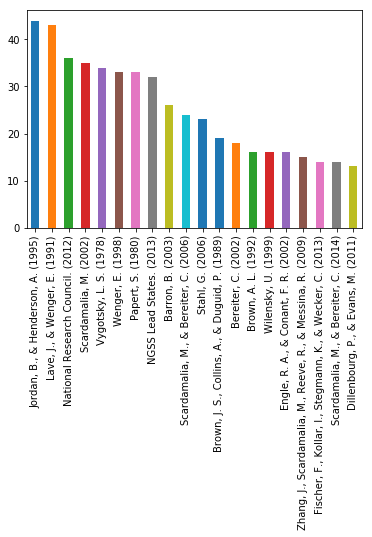

In [43]:
references_df.ref_parsed.value_counts().head(20).plot(kind='bar')

# extracting information for individual references:
## Extracting the year of publication:

In [44]:
def extract_year(x):
    match_press = r'\(in press\)'
    years = r'\([\w\d\,\ \.]*(18|19|20)\d{2}[\,\ \w\d]*\)'
    year = re.search(years, x)
    if re.search(match_press, x):
        return 2018
    if year:
        year = year.group(0)
        year = re.findall('\d{4}', year)
        return int(year[0])
    else:
        return np.nan

In [45]:
references_df.loc[~references_df.ref_parsed.isna(),'year'] = references_df[~references_df.ref_parsed.isna()].ref_parsed.map(extract_year)

In [46]:
references_df[references_df.year.isna()].shape

(166, 6)

In [47]:
references_df.year.describe()

count    14514.00000
mean      2006.07324
std         10.11591
min       1887.00000
25%       2002.00000
50%       2009.00000
75%       2013.00000
max       2018.00000
Name: year, dtype: float64

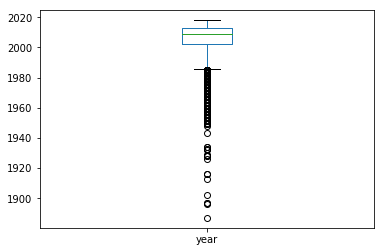

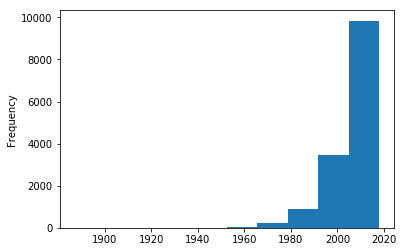

In [48]:
references_df.year.plot(kind='box')
plt.show()
references_df.year.plot(kind='hist')

In [49]:
#references_df.to_csv('../data/References.csv')

## Look at individual authors:

For now we look only the the authors that come up in any citation in the paper. So we do not care about order or the specific reference they are associated with:

We again use a regex to extract neighbours

In [50]:
authors = 'Yoon, S., Anderson, E., Koehler-Yom, Evans, C., Park, M., J., Sheldon, J., Schoenfeld, I., Wendel, D., Scheintaub, H., Klopfer, E.'

In [51]:
re.findall(r'([A-Z][^\W\d_\-]*\,?\&? [A-Z]\.\,?)', authors)

['Yoon, S.,',
 'Anderson, E.,',
 'Evans, C.,',
 'Park, M.,',
 'Sheldon, J.,',
 'Schoenfeld, I.,',
 'Wendel, D.,',
 'Scheintaub, H.,',
 'Klopfer, E.']

A change of local seems to allow for better parsing!

In [52]:
import locale
locale.setlocale(locale.LC_ALL, 'de_DE')

'de_DE'

In [53]:
regex = r'([\w\-]*[\,] [A-Z\.\ ]+[\&\,]?)'

In [54]:
authors = 'Abrahamson, D., Snüàchez-Gärca, R. S. ,'
re.findall(regex, authors, re.U)

['Abrahamson, D.,', 'Snüàchez-Gärca, R. S. ,']

In [55]:
import regex

In [171]:
#extract authors and clean strings a bit
author_split = r'([\p{L}\-]*[\,] [\p{L}\.\ \-]*[\&\,\.]?)'
author_split_2 = r'([\p{L}\-\.\ ]* [\p{L}\. \ \-]*[\,\.]?)'

regex.search(author_split_2, 'Abrahamson D., Snüàchez-Gärca R. S. ,')
regex.findall(author_split_2, 'Selwyn N. (2007)')

['Selwyn N. ']

In [172]:
def extract_author(text):
    if regex.match('^([\p{L}\ \-]*\p{Lu}\.\,)', text):
        split = [a.replace(',', '').replace('&', '').rstrip() for a in regex.findall(
            author_split_2, text[:text.find('(')])]
        return split
    else:
        split = [a.replace(',', '').replace('&', '').rstrip() for a in regex.findall(author_split, text[:text.find('(')])] 
        tmp = []
        if len(split) == 1:
            return split
        
        for f, s in zip(split[:-1], split[1:]):
            if len(s) == 1:
                tmp.append(f + s)
            else:
                tmp.append(s)
                tmp.append(f)
                
        if len(split) == 0:
            return [a.replace(',', '').replace('&', '').rstrip() for a in regex.findall(
            author_split_2, text[:text.find('(')])]

        if len(tmp) == 0:
            return split
        return tmp

In [173]:
references_df['authors'] =  references_df[~references_df.ref_parsed.isna()].ref_parsed.map(lambda x: extract_author(x))

tags = references_df.authors.apply(pd.Series)
tags = tags.rename(columns = lambda x : 'tag_' + str(x))

df = pd.concat([references_df, tags], axis=1)

tag_cols = [c for c in df.columns if 'tag' not in c]

df = df.melt(id_vars=tag_cols)

del df['variable'], df['authors']

df = df[df.value.notna()]

df.reset_index(drop=True, inplace=True)

In [174]:
ex = df[df.value.map(lambda x: len(x) < 5)]

In [175]:
ex.shape

(235, 7)

In [176]:
df.shape

(45193, 7)

In [177]:
ex.ref_parsed.map(lambda x: extract_author(x))

260                                                 [OECD]
269      [ Liu, Hmelo-Silver C. Jordan, ,  Liu, Chernob...
942                                                  [NRC]
1207                               [, F Wake, Wasson B., ]
1774                                                [OECD]
1778           [ So, Press New York. Tan, ,  So, Yeo J., ]
2148                                                [OECD]
2152                                                [B.J.]
2394                       [ M., Yang D., Rosé C. P.,  M.]
2840                           [, Aalst Chan, Wan W. S., ]
3137                                       [, Sherrill W.]
3266     [ Pea, evaluation and ethics. In Goldman,  Bar...
3369                                                [OECD]
3518                                                [ESSA]
3955                                                [OECD]
4043                                       [, Sherrill W.]
4679                                   [ L., Deiglmayr A

In [170]:
ex.ref.tolist()

['OECD (2012), Better Skills, Better Jobs, Better Lives: A Strategic Approach to Skills Policies, OECD Publishing. Retrieved October 28, 2015 from http: http://dx.doi.org/10.1787/9789264177338-en',
 'Hmelo-Silver, C. Jordan, R., Liu, L., & Chernobilsky, E. (2011). Representational tools for understanding complex computer-supported collaborative learning environments. In S. Puntambekar, G. Erkens, & C.E. Hmelo-Silver (Eds.), Analyzing Interactions in CSCL (pp. 83-106). New York: Springer.',
 'NRC (National Research Council). (2012). A framework for K-12 science education: Practices, crosscutting concepts, and core ideas. Washington, DC: National Academies Press.',
 'OECD (2010). The OECD innovation strategy. Paris: OECD Publishing.',
 'Cambridge University Press, New York. Tan, S. C., So, H. J., & Yeo, J. (Eds.). (2014). Knowledge Creation in Education. Singapore: Springer.',
 'OECD (2013). Draft PISA 2015 collaborative problem solving framework. Retrieved 1st of October 2014 from http:

In [141]:
df[df.ref == 'Bridges D., Juceviciene P., Jucevicius, R., Mclaughlin T. H., & Stankeviciute J. (2007). Higher education and national development: Universities and societies in transition. London: Routledge.']

,ref,file,length,initial,ref_parsed,year,value
2627,"Bridges D., Juceviciene P., Jucevicius, R., Mc...",import2015short_169,192,B,"Bridges D., Juceviciene P., Jucevicius, R., Mc...",2007.0,Bridges D.
5449,"Bridges D., Juceviciene P., Jucevicius, R., Mc...",import2015full_169,192,B,"Bridges D., Juceviciene P., Jucevicius, R., Mc...",2007.0,Bridges D.
16339,"Bridges D., Juceviciene P., Jucevicius, R., Mc...",import2015short_169,192,B,"Bridges D., Juceviciene P., Jucevicius, R., Mc...",2007.0,Juceviciene P.
18130,"Bridges D., Juceviciene P., Jucevicius, R., Mc...",import2015full_169,192,B,"Bridges D., Juceviciene P., Jucevicius, R., Mc...",2007.0,Juceviciene P.
24994,"Bridges D., Juceviciene P., Jucevicius, R., Mc...",import2015short_169,192,B,"Bridges D., Juceviciene P., Jucevicius, R., Mc...",2007.0,Jucevicius
26004,"Bridges D., Juceviciene P., Jucevicius, R., Mc...",import2015full_169,192,B,"Bridges D., Juceviciene P., Jucevicius, R., Mc...",2007.0,Jucevicius
30178,"Bridges D., Juceviciene P., Jucevicius, R., Mc...",import2015short_169,192,B,"Bridges D., Juceviciene P., Jucevicius, R., Mc...",2007.0,R.
31185,"Bridges D., Juceviciene P., Jucevicius, R., Mc...",import2015full_169,192,B,"Bridges D., Juceviciene P., Jucevicius, R., Mc...",2007.0,R.
34895,"Bridges D., Juceviciene P., Jucevicius, R., Mc...",import2015short_169,192,B,"Bridges D., Juceviciene P., Jucevicius, R., Mc...",2007.0,Mclaughlin T. H.
35441,"Bridges D., Juceviciene P., Jucevicius, R., Mc...",import2015full_169,192,B,"Bridges D., Juceviciene P., Jucevicius, R., Mc...",2007.0,Mclaughlin T. H.


In [142]:
ex.value.tolist()

[' B', ' W.', ' F.', ' C.', ' S', '', ' C', ' K', ' I', ' M']

In [69]:
df.sample(4)

,ref,file,length,initial,ref_parsed,value
945,"Bricker, L. A., & Bell, P. (2008). Conceptuali...",import2017_21,212,B,"Bricker, L. A., & Bell, P. (2008)",Bricker L.
150,"Xiang, L., & Passmore, C. (2015). A framework ...",import2017_60,165,X,"Xiang, L., & Passmore, C. (2015)",Xiang L.
16,"Garet, M. S., Porter, A. C., Desimone, L., Bir...",import2016full_44,225,G,"Garet, M. S., Porter, A. C., Desimone, L., Bir...",Desimone L.
486,"Ball, L. J., Onarheim, B., & Christensen, B. T...",import2018_312,186,B,"Ball, L. J., Onarheim, B., & Christensen, B. T...",Ball L.


In [143]:
#extract authors!
authors_frame = df

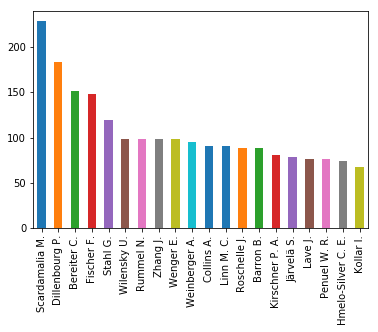

In [145]:
authors_frame.value.value_counts().head(20).plot(kind='bar')

In [146]:
authors_frame.value.value_counts().head(10)

Scardamalia M.    229
Dillenbourg P.    184
Bereiter C.       152
Fischer F.        148
Stahl G.          119
Wilensky U.        99
Rummel N.          99
Zhang J.           98
Wenger E.          98
Weinberger A.      95
Name: value, dtype: int64

In [62]:
pd.merge(authors_frame, references_df, on='file')

,author,file,ref,length,initial,ref_parsed,year
0,Lave J.,import2018_371,"Lave, J., & Wenger, E. (1991). Situated learni...",108,L,"Lave, J., & Wenger, E. (1991)",1991.0
1,Lave J.,import2018_371,"Miles, M. B., Huberman, A. M., & Saldana, J. (...",107,M,"Miles, M. B., Huberman, A. M., & Saldana, J. (...",2013.0
2,Lave J.,import2018_371,"Pea, R. D., Gomez, L. M., Edelson, D. C., Fish...",294,P,"Pea, R. D., Gomez, L. M., Edelson, D. C., Fish...",1997.0
3,Lave J.,import2018_371,"Rogoff, B. (1995). Observing sociocultural act...",269,R,"Rogoff, B. (1995)",1995.0
4,Lave J.,import2018_371,"Shirk, J., Ballard, H., Wilderman, C., Phillip...",215,S,"Shirk, J., Ballard, H., Wilderman, C., Phillip...",2012.0
5,Wenger E.,import2018_371,"Lave, J., & Wenger, E. (1991). Situated learni...",108,L,"Lave, J., & Wenger, E. (1991)",1991.0
6,Wenger E.,import2018_371,"Miles, M. B., Huberman, A. M., & Saldana, J. (...",107,M,"Miles, M. B., Huberman, A. M., & Saldana, J. (...",2013.0
7,Wenger E.,import2018_371,"Pea, R. D., Gomez, L. M., Edelson, D. C., Fish...",294,P,"Pea, R. D., Gomez, L. M., Edelson, D. C., Fish...",1997.0
8,Wenger E.,import2018_371,"Rogoff, B. (1995). Observing sociocultural act...",269,R,"Rogoff, B. (1995)",1995.0
9,Wenger E.,import2018_371,"Shirk, J., Ballard, H., Wilderman, C., Phillip...",215,S,"Shirk, J., Ballard, H., Wilderman, C., Phillip...",2012.0


In [ ]:
authors_frame.to_csv('data/Reference_authors.csv')

## Trying to extract the conference

In [ ]:
references_df[references_df.ref.map(lambda x: 'CHI' in x)].shape

In [ ]:
text = references_df.sample().ref.item()
re.split(r'\. (?=[A-Z][A-Za-z])', text)

In [ ]:
references_df[references_df.ref.map(lambda x: 'CHI' in x)].sample(4).ref.tolist()

In [ ]:
references_df[references_df.ref.map(lambda x: 'ICLS' in x)].shape

In [ ]:
text= '/hdfk/2017/r8475'
re.search('\d{3}(0|2|4|6|8)', text)

In [ ]:
references_df['conference'] = references_df.file.map(lambda x: 'ICLS' if re.search('\d{3}(0|2|4|6|8)', x) else 'CSCL')

In [ ]:
references_df[references_df.ref.map(lambda x: 'CSCL' in x)].conference.value_counts()

In [ ]:
references_df[references_df.ref.map(lambda x: 'ICLS' in x)].conference.value_counts()

In [ ]:
references_df.join(ref_counts, on='file').groupby('conference').counts.plot(kind='hist')

In [ ]:
references_df.conference.value_counts()

In [ ]:
references_df.groupby('file').conference.value_counts()

## trying to parse acm authors

We see that there aren't that many, so we won't parse them for not

In [ ]:
ACM_authors = []
for i, ref in enumerate(references):
    for sentence in ref:
        s =  re.findall(r'[a-zA-Z\ \. \,]*\d{4}\. ', sentence)
        if re.match(r'[a-zA-Z\ \. \,]*\d{4}\. ', sentence) and not 'http' in s[0].lower() and len(s[0]) > 10:
            #print(sentence)
            print(s[0])
            #apa_authors.append((re.findall(r'.*\(\d{4}\)', sentence)[0], source[i]))

In [ ]:
re.match(r'(.*\d{4}\. )', "https://www.nsf.gov/funding/pgm_summ.jsp?pims_id=5467. Retrieved August 19, 2016.")

In [ ]:
m = re.match(r'.*\d{4}\. ', 'https://www.nsf.gov/funding/pgm_summ.jsp?pims_id=5467. Retrieved August 19, 2016.')

In [ ]:
re.findall(r'[a-zA-Z\ \. \,]*\d{4}\. ', 'McKenzie, W., and Murphy, D. 2000. “I hope this goes somewhere”: Evaluation of an on')